In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Video segmentation with SAM 2

This notebook shows how to use SAM 2 for interactive segmentation in videos. It will cover the following:

- adding clicks (or box) on a frame to get and refine _masklets_ (spatio-temporal masks)
- propagating clicks (or box) to get _masklets_ throughout the video
- segmenting and tracking multiple objects at the same time

We use the terms _segment_ or _mask_ to refer to the model prediction for an object on a single frame, and _masklet_ to refer to the spatio-temporal masks across the entire video. 

<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/video_predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Environment Set-up

If running locally using jupyter, first install `sam2` in your environment using the [installation instructions](https://github.com/facebookresearch/sam2#installation) in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

In [33]:
using_colab = False

## Set-up

In [3]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


### Loading the SAM 2 video predictor

In [5]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [6]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

#### Select an example video

We assume that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`.

For your custom videos, you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from `00000.jpg`.

In [7]:
import subprocess
import os
from pathlib import Path

def video_to_frames(input_video, output_dir, quality=2):
    """
    Convert a video file to a sequence of JPG frames.
    
    Args:
        input_video (str): Path to input video file
        output_dir (str): Directory to save the frames
        quality (int): JPEG quality (1-31, lower is better quality, 2 is recommended)
    
    Returns:
        int: Number of frames created, or -1 if error occurred
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Construct the ffmpeg command
    ffmpeg_cmd = [
        'ffmpeg',
        '-i', input_video,
        '-q:v', str(quality),
        '-start_number', '0',
        os.path.join(output_dir, '%05d.jpg')
    ]
    
    try:
        result = subprocess.run(
            ffmpeg_cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        
        if result.returncode == 0:
            num_frames = len([f for f in os.listdir(output_dir) if f.endswith('.jpg')])
            print(f"Successfully created {num_frames} frames from {input_video}")
            return num_frames
        else:
            print(f"Error processing {input_video}:")
            print(result.stderr)
            return -1
            
    except Exception as e:
        print(f"Error processing {input_video}: {str(e)}")
        return -1

# Example usage for multiple videos:


In [8]:
video_dir = "G:/SAM2/data_samples/babbling_eye_lid_tracking/"
videos = [f for f in os.listdir(video_dir) if f.endswith('.mp4')] #'.mov'

for video in videos:
    input_path = os.path.join(video_dir, video)
    output_dir = os.path.join(video_dir, Path(video).stem)
    video_to_frames(input_path, output_dir)

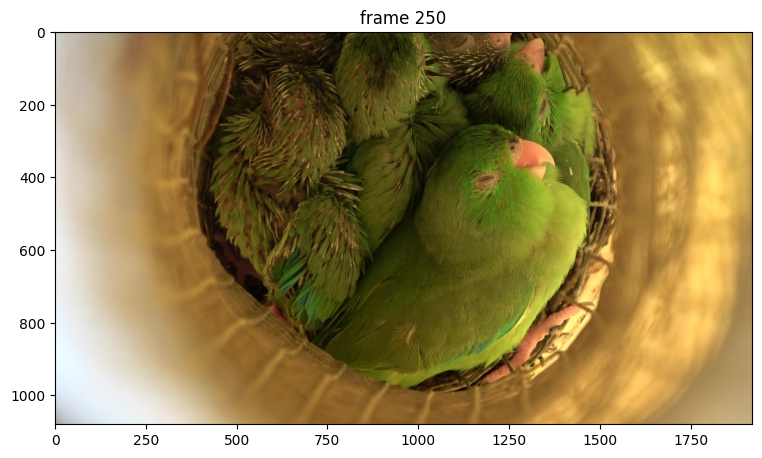

In [9]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "G:/SAM2/data_samples/babbling_eye_lid_tracking/18B104_0725_0011_0640_Movie2/" #"G:/SAM2/data_samples/babbling_eye_lid_tracking/18B104_0725_0011_0640_Movie2/"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 250
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

#### Initialize the inference state

SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [47]:
import cv2
import os
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import shutil

class VideoChunkProcessor:
    def __init__(self, predictor, video_dir, chunk_size=500, **kwargs):
        """
        Initialize the VideoChunkProcessor.
        
        Args:
            predictor: The predictor model to use for mask propagation
            video_dir: Directory containing the video frames
            chunk_size: Number of frames to process in each chunk (default: 500)
            **kwargs: Additional arguments (ignored, for backwards compatibility)
        """
        self.predictor = predictor
        self.video_dir = video_dir
        self.chunk_size = chunk_size
        
        if not os.path.exists(self.video_dir):
            raise FileNotFoundError(f"Video directory {self.video_dir} does not exist!")
        
        # Load and validate frame names once
        self.frame_names = sorted(
            [p for p in os.listdir(self.video_dir) 
             if os.path.splitext(p)[-1].lower() in [".jpg", ".jpeg"]],
            key=lambda p: int(os.path.splitext(p)[0])
        )
        
        if not self.frame_names:
            raise ValueError("No frames found in the specified directory!")
        
        # Calculate chunks without overlap
        self.chunks = self._calculate_chunks()
        print(f"Created {len(self.chunks)} chunks of {chunk_size} frames each")
    def save_results(self, output_path, fps=30, show_original=True, alpha=0.5):
        """
        Save all results including video, COCO annotations, and time series metrics
        """
        # Save video first
        self.save_results_video(output_path, fps, show_original, alpha)
        
        # Save COCO annotations
        self._save_coco_annotations(os.path.join(os.path.dirname(output_path), "segmentation_coco.json"))
        
        # Save time series metrics
        self._save_time_series(os.path.join(os.path.dirname(output_path), "time_series_metrics.csv"))
        
    def _compute_box_from_mask(self, mask):
        """Compute bounding box from mask"""
        # Ensure mask is 2D boolean array
        if len(mask.shape) > 2:
            mask = mask.squeeze()
        mask = mask.astype(bool)
        
        # Find coordinates of mask pixels
        coords = np.argwhere(mask)
        if len(coords) == 0:
            return None
            
        # Get bounding box coordinates with padding
        padding = 10
        y0, x0 = coords.min(axis=0)
        y1, x1 = coords.max(axis=0)
        
        # Add padding
        x0 = max(0, x0 - padding)
        x1 = x1 + padding
        y0 = max(0, y0 - padding)
        y1 = y1 + padding
        
        return [int(x0), int(y0), int(x1), int(y1)]
    
    def _compute_centroid(self, mask):
        """Calculate centroid of a binary mask"""
        if not mask.any():
            return None
        
        # Ensure mask is 2D boolean array
        if len(mask.shape) > 2:
            mask = mask.squeeze()
        mask = mask.astype(bool)
        
        # Get coordinates of True values
        y_coords, x_coords = np.where(mask)
        
        if len(y_coords) == 0:
            return None
            
        # Calculate centroid
        centroid_y = np.mean(y_coords)
        centroid_x = np.mean(x_coords)
        
        return (centroid_y, centroid_x)
    
    def _compute_metrics(self, mask, box, frame):
        """
        Compute metrics from mask, bounding box, and frame
        
        Args:
            mask: Binary segmentation mask
            box: [x1, y1, x2, y2] bounding box coordinates
            frame: Original frame (BGR image) for color analysis
        
        Returns:
            Dictionary of metrics or None if invalid input
        """
        if box is None or mask is None or frame is None:
            return None
        
        # Ensure mask is 2D boolean array
        if len(mask.shape) > 2:
            mask = mask.squeeze()
        mask = mask.astype(bool)
        
        # Box coordinates
        x1, y1, x2, y2 = box
        
        # Box centroid
        box_centroid_x = (x1 + x2) / 2
        box_centroid_y = (y1 + y2) / 2
        
        # Mask centroid
        y_coords, x_coords = np.where(mask)
        if len(y_coords) == 0:
            return None
            
        seg_centroid_y = np.mean(y_coords)
        seg_centroid_x = np.mean(x_coords)
        
        # Surface area (number of True pixels in mask)
        surface_area = np.sum(mask)
        
        # Color analysis
        masked_pixels = frame[mask]  # Get all pixels within mask
        mean_color = np.mean(masked_pixels, axis=0)  # BGR format
        std_color = np.std(masked_pixels, axis=0)
        
        return {
            'box_x1': x1,
            'box_y1': y1,
            'box_x2': x2,
            'box_y2': y2,
            'box_centroid_x': box_centroid_x,
            'box_centroid_y': box_centroid_y,
            'seg_centroid_y': float(seg_centroid_y),
            'seg_centroid_x': float(seg_centroid_x),
            'surface_area': surface_area,
            'mean_color_b': float(mean_color[0]),
            'mean_color_g': float(mean_color[1]),
            'mean_color_r': float(mean_color[2]),
            'std_color_b': float(std_color[0]),
            'std_color_g': float(std_color[1]),
            'std_color_r': float(std_color[2]),
            'color_intensity': float(np.mean(mean_color))
        }
    def _save_coco_annotations(self, json_path):
        """Save annotations in COCO format"""
        current_time = datetime.now().strftime("%a %b %d %Y %H:%M:%S GMT%z (%Z)")
        coco_data = {
            "info": {
                "year": datetime.now().year,
                "version": "1.0",
                "description": "VIA project exported to COCO format using SAM2",
                "contributor": "SAM2 & Wim Pouw",
                "url": "NA",
                "date_created": current_time
            },
            "images": [],
            "annotations": [],
            "licenses": [{"id": 0, "name": "Unknown License", "url": ""}],
            "categories": [{"supercategory": "animal_body", "id": 1, "name": "animal_body"}]
        }
        
        # Add images
        unique_ids = {}
        for idx, frame_name in enumerate(self.frame_names, 1):
            img = cv2.imread(os.path.join(self.video_dir, frame_name))
            height, width = img.shape[:2]
            coco_data["images"].append({
                "id": idx,
                "width": width,
                "height": height,
                "file_name": frame_name,
                "license": 0,
                "date_captured": ""
            })
            unique_ids[frame_name] = idx
        
        # Add annotations
        annotation_id = 1
        for frame_idx in self.results:
            current_frame = self.frame_names[frame_idx]
            for obj_id, mask in self.results[frame_idx].items():
                if len(mask.shape) > 2:
                    mask = mask.squeeze()
                mask_bool = mask.astype(np.uint8) * 255
                
                contours, _ = cv2.findContours(mask_bool, cv2.RETR_EXTERNAL, 
                                             cv2.CHAIN_APPROX_SIMPLE)
                
                if contours:
                    contour = max(contours, key=cv2.contourArea)
                    epsilon = 0.005 * cv2.arcLength(contour, True)
                    approx = cv2.approxPolyDP(contour, epsilon, True)
                    
                    flattened = []
                    for point in approx:
                        flattened.extend([int(point[0][0]), int(point[0][1])])
                    
                    box = compute_box_from_mask(mask)
                    if box is not None:
                        x1, y1, x2, y2 = box
                        bbox = [x1, y1, x2 - x1, y2 - y1]
                        area = int(cv2.contourArea(contour))
                        
                        coco_data["annotations"].append({
                            "segmentation": [flattened],
                            "area": area,
                            "bbox": bbox,
                            "iscrowd": 0,
                            "id": annotation_id,
                            "image_id": unique_ids[current_frame],
                            "category_id": 1
                        })
                        annotation_id += 1
        
        with open(json_path, 'w', encoding='utf-8') as f:
            json.dump(coco_data, f)
        print(f"Saved COCO annotations to: {json_path}")
    
    def _save_time_series(self, csv_path):
        """Save time series metrics for each object"""
        import pandas as pd
        
        metrics_data = []
        
        for frame_idx in sorted(self.results.keys()):
            frame = self.frame_names[frame_idx]
            original_frame = cv2.imread(os.path.join(self.video_dir, frame))
            
            for obj_id, mask in self.results[frame_idx].items():
                # Compute basic metrics
                box = compute_box_from_mask(mask)
                if box is None:
                    continue
                    
                metrics = compute_metrics(mask, box)
                if metrics is None:
                    continue
                
                # Compute color changes in masked region
                if len(mask.shape) > 2:
                    mask = mask.squeeze()
                mask_bool = mask.astype(bool)
                masked_colors = original_frame[mask_bool]
                
                # Add color metrics
                metrics.update({
                    'frame': frame_idx,
                    'frame_name': frame,
                    'object_id': obj_id,
                    'mean_color_r': np.mean(masked_colors[:, 2]),  # OpenCV uses BGR
                    'mean_color_g': np.mean(masked_colors[:, 1]),
                    'mean_color_b': np.mean(masked_colors[:, 0]),
                    'std_color_r': np.std(masked_colors[:, 2]),
                    'std_color_g': np.std(masked_colors[:, 1]),
                    'std_color_b': np.std(masked_colors[:, 0])
                })
                
                metrics_data.append(metrics)
        
        # Convert to DataFrame and save
        df = pd.DataFrame(metrics_data)
        
        # Calculate changes between frames
        df['delta_centroid_x'] = df.groupby('object_id')['seg_centroid_x'].diff()
        df['delta_centroid_y'] = df.groupby('object_id')['seg_centroid_y'].diff()
        df['delta_area'] = df.groupby('object_id')['surface_area'].diff()
        
        # Save to CSV
        df.to_csv(csv_path, index=False)
        print(f"Saved time series metrics to: {csv_path}")
    def _calculate_chunks(self):
        """Calculate chunks without overlap"""
        chunks = []
        frame_count = len(self.frame_names)
        
        for start in range(0, frame_count, self.chunk_size):
            end = min(start + self.chunk_size, frame_count)
            chunks.append({
                'start': start,
                'end': end,
                'frame_names': self.frame_names[start:end]
            })
        
        return chunks

    def _get_mask_boundary_points(self, mask, num_boundary_points=4, num_interior_points=6, num_negative_points=24, debug_viz=False):
        """Extract points from a binary mask for propagation with wider negative boundary."""
        import numpy as np
        
        if not mask.any():
            return None, None
            
        # Find contours of the mask
        contours, _ = cv2.findContours((mask > 0).astype(np.uint8), 
                                     cv2.RETR_EXTERNAL, 
                                     cv2.CHAIN_APPROX_SIMPLE)
        
        if not contours:
            return None, None
            
        # Get the largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        points = []
        labels = []
        
        # Debug visualization setup
        debug_img = None
        if debug_viz:
            debug_img = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
            debug_img[mask > 0] = [128, 128, 128]  # Gray for mask
        
        # Get minimal boundary points
        if num_boundary_points > 0:
            # Get extreme points of contour
            leftmost = tuple(largest_contour[largest_contour[:,:,0].argmin()][0])
            rightmost = tuple(largest_contour[largest_contour[:,:,0].argmax()][0])
            topmost = tuple(largest_contour[largest_contour[:,:,1].argmin()][0])
            bottommost = tuple(largest_contour[largest_contour[:,:,1].argmax()][0])
            
            extremes = [leftmost, rightmost, topmost, bottommost]
            points.extend(extremes[:num_boundary_points])
            labels.extend([1] * num_boundary_points)
            
            if debug_viz:
                for pt in extremes[:num_boundary_points]:
                    cv2.circle(debug_img, pt, 3, (0, 255, 0), -1)  # Green for positive points
        
        # Get minimal interior points
        # Get interior points with better distribution
        if num_interior_points > 0:
            moments = cv2.moments(mask.astype(np.uint8))
            if moments['m00'] != 0:
                cx = int(moments['m10'] / moments['m00'])
                cy = int(moments['m01'] / moments['m00'])
        
                # Add centroid first
                if mask[cy, cx]:  # Only add if actually inside mask
                    points.append([cx, cy])
                    labels.append(1)
                    if debug_viz:
                        cv2.circle(debug_img, (cx, cy), 3, (0, 255, 0), -1)
        
                # Calculate multiple radii for better coverage
                max_radius = min(w, h) // 4  # Use 1/4th of min dimension
                angles = np.linspace(0, 2 * np.pi, num_interior_points)
                radii = np.linspace(max_radius * 0.2, max_radius, 3)  # Multiple radius rings
        
                for radius in radii:
                    for angle in angles:
                        x = cx + int(radius * np.cos(angle))
                        y = cy + int(radius * np.sin(angle))
                        
                        # Verify point is within image bounds and mask
                        if (0 <= x < mask.shape[1] and 0 <= y < mask.shape[0] and 
                            mask[y, x]):
                            points.append([x, y])
                            labels.append(1)
                            if debug_viz:
                                cv2.circle(debug_img, (x, y), 3, (0, 255, 0), -1)
        
        # Create negative points in a wider ring
        if num_negative_points > 0:
            # Create wider boundary for negative points
            expansion = max(w, h) // 10  # Use 10% of mask size for expansion
            kernel = np.ones((expansion, expansion), np.uint8)
            dilated = cv2.dilate(mask.astype(np.uint8), kernel, iterations=1)
            outer_region = dilated & (~mask)
            
            if debug_viz:
                debug_img[outer_region > 0] = [0, 0, 192]  # Dark red for negative region
            
            # Sample evenly spaced points around the expanded boundary
            ys, xs = np.where(outer_region > 0)
            if len(xs) > 0:
                # Sample points with equal spacing along the expanded boundary
                indices = np.linspace(0, len(xs) - 1, num_negative_points, dtype=int)
                negative_points = np.column_stack([xs[indices], ys[indices]])
                
                # Add some random offset to avoid perfect circle
                for i in range(len(negative_points)):
                    offset = np.random.randint(-expansion//2, expansion//2, size=2)
                    pt = negative_points[i] + offset
                    pt[0] = np.clip(pt[0], 0, mask.shape[1]-1)
                    pt[1] = np.clip(pt[1], 0, mask.shape[0]-1)
                    if not mask[pt[1], pt[0]]:  # Only add if outside mask
                        points.append(pt)
                        labels.append(0)
                        if debug_viz:
                            cv2.circle(debug_img, (int(pt[0]), int(pt[1])), 3, (0, 0, 255), -1)
        
        #if debug_viz:
            #cv2.imshow('Point Selection Debug', debug_img)
            #cv2.waitKey(1)  # Show for a brief moment, but don't block
        
        if not points:
            return None, None
            
        return np.array(points, dtype=np.float32), np.array(labels, dtype=np.int32)

    def process_video(self, points_dict, labels_dict, debug=True):
        """Process video in forward chunks starting from first frame"""
        results = {}
        
        # Process first chunk with original points
        chunk = self.chunks[0]
        temp_dir = os.path.join(self.video_dir, "chunk_0")
        
        try:
            os.makedirs(temp_dir, exist_ok=True)
            for frame_name in chunk['frame_names']:
                src = os.path.join(self.video_dir, frame_name)
                dst = os.path.join(temp_dir, frame_name)
                if not os.path.exists(dst):
                    shutil.copy2(src, dst)
            
            chunk_state = self.predictor.init_state(video_path=temp_dir)
            
            # Process first chunk with input points
            for obj_id in points_dict:
                self.predictor.reset_state(chunk_state)
                points = np.array(points_dict[obj_id], dtype=np.float32)
                labels = np.array(labels_dict[obj_id], dtype=np.int32)
                
                if debug:
                    print(f"\nInitial points for object {obj_id}:")
                    print(f"Positive points: {sum(labels == 1)}")
                    print(f"Negative points: {sum(labels == 0)}")
                
                _, obj_ids, mask_logits = self.predictor.add_new_points_or_box(
                    inference_state=chunk_state,
                    frame_idx=0,  # Always start from first frame
                    obj_id=obj_id,
                    points=points,
                    labels=labels
                )
                
                # Store results and propagate
                for i, prop_obj_id in enumerate(obj_ids):
                    mask = (mask_logits[i] > 0.0).cpu().numpy()
                    if len(mask.shape) == 3:
                        mask = mask[0]
                    results[0] = {prop_obj_id: mask}
                    
                    for frame_idx, prop_obj_ids, prop_mask_logits in self.predictor.propagate_in_video(chunk_state):
                        global_frame_idx = frame_idx
                        mask = (prop_mask_logits[i] > 0.0).cpu().numpy()
                        if len(mask.shape) == 3:
                            mask = mask[0]
                        if global_frame_idx not in results:
                            results[global_frame_idx] = {}
                        results[global_frame_idx][prop_obj_id] = mask
        
        finally:
            if os.path.exists(temp_dir):
                shutil.rmtree(temp_dir)
        
        # Process remaining chunks using masks from previous chunks
        for chunk_idx in range(1, len(self.chunks)):
            chunk = self.chunks[chunk_idx]
            temp_dir = os.path.join(self.video_dir, f"chunk_{chunk_idx}")
            
            try:
                os.makedirs(temp_dir, exist_ok=True)
                for frame_name in chunk['frame_names']:
                    src = os.path.join(self.video_dir, frame_name)
                    dst = os.path.join(temp_dir, frame_name)
                    if not os.path.exists(dst):
                        shutil.copy2(src, dst)
                
                chunk_state = self.predictor.init_state(video_path=temp_dir)
                
                # Get mask from last frame of previous chunk
                prev_chunk = self.chunks[chunk_idx - 1]
                prev_last_frame = prev_chunk['end'] - 1
                
                for obj_id in points_dict:
                    if prev_last_frame not in results or obj_id not in results[prev_last_frame]:
                        print(f"Warning: No mask found in previous chunk for object {obj_id}")
                        continue
                    
                    self.predictor.reset_state(chunk_state)
                    mask = results[prev_last_frame][obj_id]
                    # Ensure mask is 2D
                    if len(mask.shape) == 3:
                        mask = mask[0]
                    
                    # Get points with debug visualization
                    points, labels = self._get_mask_boundary_points(mask, debug_viz=debug)
                    
                    if points is None:
                        print(f"Warning: Could not generate points for object {obj_id} in chunk {chunk_idx}")
                        continue
                    
                    if debug:
                        print(f"\nChunk {chunk_idx}, object {obj_id}:")
                        print(f"Positive points: {sum(labels == 1)}")
                        print(f"Negative points: {sum(labels == 0)}")
                    
                    # Propagate through chunk
                    _, obj_ids, mask_logits = self.predictor.add_new_points_or_box(
                        inference_state=chunk_state,
                        frame_idx=0,
                        obj_id=obj_id,
                        points=points,
                        labels=labels
                    )
                    
                    for i, prop_obj_id in enumerate(obj_ids):
                        mask = (mask_logits[i] > 0.0).cpu().numpy()
                        if chunk['start'] not in results:
                            results[chunk['start']] = {}
                        results[chunk['start']][prop_obj_id] = mask
                        
                        for frame_idx, prop_obj_ids, prop_mask_logits in self.predictor.propagate_in_video(chunk_state):
                            global_frame_idx = chunk['start'] + frame_idx
                            if global_frame_idx not in results:
                                results[global_frame_idx] = {}
                            mask = (prop_mask_logits[i] > 0.0).cpu().numpy()
                            results[global_frame_idx][prop_obj_id] = mask
            
            finally:
                if os.path.exists(temp_dir):
                    shutil.rmtree(temp_dir)
        
        return results
        
    def save_results_video(self, results, output_path, fps=30, show_original=True, alpha=0.5):
        """
        Save the processing results as a video file
        
        Args:
            results: Dictionary of frame results
            output_path: Path to save the video
            fps: Frames per second (default: 30)
            show_original: Whether to show original frame alongside result (default: True)
            alpha: Opacity of mask overlay (0 to 1, where 1 is fully opaque) (default: 0.5)
        """
        if not results:
            print("No results to save!")
            return
    
        # Validate alpha value
        alpha = max(0.0, min(1.0, alpha))  # Clamp between 0 and 1
        
        # Get video dimensions from first frame
        first_frame = cv2.imread(os.path.join(self.video_dir, self.frame_names[0]))
        height, width = first_frame.shape[:2]
    
        # Create color map for different objects
        cmap = plt.get_cmap("tab10")
        
        # Initialize video writer
        if show_original:
            out_width = width * 2
        else:
            out_width = width
            
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (out_width, height))
    
        print("\nSaving video...")
        for frame_idx in tqdm(range(len(self.frame_names))):
            # Load original frame
            frame = cv2.imread(os.path.join(self.video_dir, self.frame_names[frame_idx]))
            if frame is None:
                continue
                
            # Start with original frame for overlay
            overlay = frame.copy()
            
            if frame_idx in results:
                for obj_id, mask in results[frame_idx].items():
                    # Ensure mask is 2D
                    if len(mask.shape) == 3:
                        mask = mask[0]
                    
                    # Resize mask if needed
                    if mask.shape != (height, width) and mask.shape[0] > 0 and mask.shape[1] > 0:
                        try:
                            mask = cv2.resize(mask.astype(np.float32), (width, height), 
                                            interpolation=cv2.INTER_LINEAR) > 0.5
                        except cv2.error:
                            print(f"Warning: Could not resize mask for frame {frame_idx}, object {obj_id}")
                            continue
                    
                    if mask.shape == (height, width):
                        # Create colored mask
                        color = np.array(cmap(obj_id % 10)[:3]) * 255
                        
                        # Only modify pixels where mask is True
                        if alpha == 1.0:
                            # Fully opaque - directly set colors where mask is True
                            for c in range(3):
                                overlay[:, :, c][mask] = color[c]
                        else:
                            # Semi-transparent - blend only masked regions
                            color_mask = np.zeros_like(overlay)
                            for c in range(3):
                                color_mask[:, :, c][mask] = color[c]
                            
                            # Only blend where mask is True
                            blend_mask = np.zeros_like(overlay)
                            cv2.addWeighted(overlay, 1.0 - alpha, color_mask, alpha, 0, blend_mask)
                            overlay[mask] = blend_mask[mask]
            
            if show_original:
                output_frame = np.concatenate([frame, overlay], axis=1)
            else:
                output_frame = overlay
                
            out.write(output_frame)
    
        out.release()
        print(f"Video saved to: {output_path}")
        
    def create_analysis_video(self, results, output_path, fps=30, alpha=0.5):
        """
        Create analysis video with masked overlay and surrounding plots
        
        Args:
            results: Dictionary of results from process_video
            output_path: Where to save the analysis video
            fps: Frames per second for output video
            alpha: Opacity of mask overlay (0 to 1)
        """
        import matplotlib.pyplot as plt
        from matplotlib.figure import Figure
        from matplotlib.backends.backend_agg import FigureCanvasAgg
        
        if not results:
            print("No results to analyze!")
            return
        
        # Get color map
        cmap = plt.get_cmap("tab10")
        
        # Collect time series data (same as before)
        print("Collecting time series data...")
        time_series_data = {}
        max_frame_idx = max(results.keys())
        
        for obj_id in set(obj_id for frame in results.values() for obj_id in frame.keys()):
            time_series_data[obj_id] = {
                'frames': [],
                'centroids': [],
                'areas': [],
                'colors_rgb': [],
                'plot_color': cmap(obj_id % 10)[:3]  # Store plot color to match mask
            }
        
        # Calculate metrics for all frames
        for frame_idx in sorted(results.keys()):
            frame = cv2.imread(os.path.join(self.video_dir, self.frame_names[frame_idx]))
            
            for obj_id, mask in results[frame_idx].items():
                box = self._compute_box_from_mask(mask)
                metrics = self._compute_metrics(mask, box, frame)
                if metrics is None:
                    continue
                    
                data = time_series_data[obj_id]
                data['frames'].append(frame_idx)
                data['centroids'].append((metrics['seg_centroid_x'], metrics['seg_centroid_y']))
                data['areas'].append(metrics['surface_area'])
                data['colors_rgb'].append([metrics['mean_color_r'], 
                                         metrics['mean_color_g'], 
                                         metrics['mean_color_b']])
        
        # Calculate derived metrics
        print("Calculating derived metrics...")
        window_size = 10
        for obj_id in time_series_data:
            data = time_series_data[obj_id]
            
            # Convert to numpy arrays
            centroids = np.array(data['centroids'])
            if len(centroids) > 1:
                data['movement'] = np.sqrt(np.sum(np.diff(centroids, axis=0)**2, axis=1))
                data['movement'] = np.insert(data['movement'], 0, 0)
            else:
                data['movement'] = np.array([0])
            
            colors = np.array(data['colors_rgb'])
            data['color_change'] = np.linalg.norm(np.diff(colors, axis=0), axis=1)
            data['color_change'] = np.insert(data['color_change'], 0, 0)
            
            # Calculate moving averages
            data['area_ma'] = np.convolve(data['areas'], 
                                         np.ones(window_size)/window_size, 
                                         mode='same')
            data['movement_ma'] = np.convolve(data['movement'],
                                             np.ones(window_size)/window_size,
                                             mode='same')
            data['color_ma'] = np.convolve(data['color_change'],
                                          np.ones(window_size)/window_size,
                                          mode='same')
        
        # Video setup
        first_frame = cv2.imread(os.path.join(self.video_dir, self.frame_names[0]))
        height, width = first_frame.shape[:2]
        
        # Layout calculation
        n_objects = len(time_series_data)
        side_plot_height = height // n_objects  # Each side plot gets equal height
        side_plot_width = width // 3           # Side plots are 1/3 width
        bottom_plot_height = height // 4       # Bottom plots are 1/4 height
        
        # Total output dimensions
        out_width = width + (2 * side_plot_width)  # Main video + left & right plots
        out_height = height + bottom_plot_height    # Main video + bottom plots
        
        # Video position in output frame
        video_x = side_plot_width
        video_y = 0
        
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (out_width, out_height))
        
        print("\nCreating analysis video...")
        for frame_idx in tqdm(range(len(self.frame_names))):
            # Create output canvas
            output_frame = np.zeros((out_height, out_width, 3), dtype=np.uint8)
            
            # Create masked overlay
            frame = cv2.imread(os.path.join(self.video_dir, self.frame_names[frame_idx]))
            overlay = frame.copy()
            
            # Store mask centroids for connection lines
            centroids = {}
            
            if frame_idx in results:
                for obj_id, mask in results[frame_idx].items():
                    if len(mask.shape) == 3:
                        mask = mask[0]
                    if mask.shape != (height, width):
                        try:
                            mask = cv2.resize(mask.astype(np.float32), (width, height), 
                                            interpolation=cv2.INTER_LINEAR) > 0.5
                        except cv2.error:
                            continue
                    
                    # Calculate centroid for connection lines
                    moments = cv2.moments(mask.astype(np.uint8))
                    if moments['m00'] != 0:
                        cx = int(moments['m10'] / moments['m00'])
                        cy = int(moments['m01'] / moments['m00'])
                        centroids[obj_id] = (cx + video_x, cy + video_y)
                    
                    color = np.array(cmap(obj_id % 10)[:3]) * 255
                    color_mask = np.zeros_like(overlay)
                    for c in range(3):
                        color_mask[:, :, c][mask] = color[c]
                    
                    blend_mask = np.zeros_like(overlay)
                    cv2.addWeighted(overlay, 1.0 - alpha, color_mask, alpha, 0, blend_mask)
                    overlay[mask] = blend_mask[mask]
            
            # Place video in center
            output_frame[video_y:video_y+height, video_x:video_x+width] = overlay
            
            # Create and place plots for each object
            for i, (obj_id, data) in enumerate(time_series_data.items()):
                plot_color = data['plot_color']
                color_rgb = tuple(int(c * 255) for c in plot_color)
                
                # Left plot (Movement)
                fig_left = Figure(figsize=(side_plot_width/100, side_plot_height/100), dpi=100)
                ax_left = fig_left.add_subplot(111)
                ax_left.plot(data['frames'], data['movement'], color=plot_color, alpha=0.5)
                ax_left.plot(data['frames'], data['movement_ma'], color=plot_color, linewidth=2)
                ax_left.set_xlim(0, max_frame_idx)
                ax_left.axvline(frame_idx, color='k', linestyle='--', alpha=0.5)
                ax_left.set_title(f'Movement (Obj {obj_id})')
                fig_left.tight_layout()
                
                canvas = FigureCanvasAgg(fig_left)
                canvas.draw()
                plot_img = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
                plot_img = plot_img.reshape(canvas.get_width_height()[::-1] + (3,))
                
                y_offset = i * side_plot_height
                output_frame[y_offset:y_offset+side_plot_height, :side_plot_width] = plot_img
                
                # Draw connection line from left plot to mask
                if obj_id in centroids:
                    # Get current value in time series
                    current_idx = min(frame_idx, len(data['frames'])-1)
                    value = data['movement_ma'][current_idx]  # Use smoothed value
                    
                    # Convert value to y-coordinate in plot space
                    y_range = ax_left.get_ylim()
                    plot_height = side_plot_height
                    y_plot = plot_height - ((value - y_range[0]) / (y_range[1] - y_range[0]) * plot_height)
                    y_plot = int(y_offset + y_plot)
                    
                    # Draw connection from current point to mask centroid
                    start_point = (side_plot_width-5, y_plot)
                    end_point = centroids[obj_id]
                    # Add slight transparency to line
                    cv2.line(output_frame, start_point, end_point, color_rgb, 1, cv2.LINE_AA)
                    
                # Right plot (Area)
                fig_right = Figure(figsize=(side_plot_width/100, side_plot_height/100), dpi=100)
                ax_right = fig_right.add_subplot(111)
                ax_right.plot(data['frames'], data['areas'], color=plot_color, alpha=0.5)
                ax_right.plot(data['frames'], data['area_ma'], color=plot_color, linewidth=2)
                ax_right.set_xlim(0, max_frame_idx)
                ax_right.axvline(frame_idx, color='k', linestyle='--', alpha=0.5)
                ax_right.set_title('Area')
                fig_right.tight_layout()
                
                canvas = FigureCanvasAgg(fig_right)
                canvas.draw()
                plot_img = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
                plot_img = plot_img.reshape(canvas.get_width_height()[::-1] + (3,))
                
                output_frame[y_offset:y_offset+side_plot_height, 
                            video_x+width:] = plot_img
                
                # Draw connection line from right plot to mask
                if obj_id in centroids:
                    current_idx = min(frame_idx, len(data['frames'])-1)
                    value = data['area_ma'][current_idx]
                    
                    y_range = ax_right.get_ylim()
                    plot_height = side_plot_height
                    y_plot = plot_height - ((value - y_range[0]) / (y_range[1] - y_range[0]) * plot_height)
                    y_plot = int(y_offset + y_plot)
                    
                    start_point = (video_x+width+5, y_plot)
                    end_point = centroids[obj_id]
                    cv2.line(output_frame, start_point, end_point, color_rgb, 1, cv2.LINE_AA)
                
                # Bottom plot (Color Change)
                bottom_plot_width = width // n_objects
                fig_bottom = Figure(figsize=(bottom_plot_width/100, bottom_plot_height/100), dpi=100)
                ax_bottom = fig_bottom.add_subplot(111)
                ax_bottom.plot(data['frames'], data['color_change'], color=plot_color, alpha=0.5)
                ax_bottom.plot(data['frames'], data['color_ma'], color=plot_color, linewidth=2)
                ax_bottom.set_xlim(0, max_frame_idx)
                ax_bottom.axvline(frame_idx, color='k', linestyle='--', alpha=0.5)
                ax_bottom.set_title('Color Change')
                fig_bottom.tight_layout()
                
                canvas = FigureCanvasAgg(fig_bottom)
                canvas.draw()
                plot_img = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
                plot_img = plot_img.reshape(canvas.get_width_height()[::-1] + (3,))
                
                x_offset = video_x + (i * bottom_plot_width)
                output_frame[height:, x_offset:x_offset+bottom_plot_width] = plot_img
                
                # Draw connection line from bottom plot to mask
                if obj_id in centroids:
                    current_idx = min(frame_idx, len(data['frames'])-1)
                    value = data['color_ma'][current_idx]
                    
                    # For bottom plot, we connect from current x position
                    x_plot = int(x_offset + (frame_idx / max_frame_idx * bottom_plot_width))
                    
                    start_point = (x_plot, height+5)
                    end_point = centroids[obj_id]
                    cv2.line(output_frame, start_point, end_point, color_rgb, 1, cv2.LINE_AA)
                
                plt.close('all')
            
            out.write(output_frame)
        
        out.release()
        print(f"Analysis video saved to: {output_path}")
        
def select_points_opencv(frame, processor=None):
    """Interactive point selection tool with mask preview capability"""
    points_dict = {}
    labels_dict = {}
    current_obj_id = 1
    
    # Setup for mask testing
    temp_dir = "temp_select"
    if processor is not None:
        try:
            # Ensure temp directory is clean
            if os.path.exists(temp_dir):
                shutil.rmtree(temp_dir)
            os.makedirs(temp_dir)
            
            # Save frame and initialize processor
            frame_path = os.path.join(temp_dir, "0.jpg")  # Use numbered filename
            cv2.imwrite(frame_path, frame)
            print(f"Saved frame to {frame_path}")
            
            # Initialize processor state
            chunk_state = processor.predictor.init_state(video_path=temp_dir)
            if chunk_state is None:
                raise ValueError("Failed to initialize chunk state")
            print("Successfully initialized processor state")
            
        except Exception as e:
            print(f"Error initializing processor: {str(e)}")
            import traceback
            traceback.print_exc()
            if os.path.exists(temp_dir):
                shutil.rmtree(temp_dir)
            return None, None
    
    def draw_point(img, point, obj_id, label):
        """Draw a point with appropriate color and label"""
        color = (0, 255, 0) if label == 1 else (0, 0, 255)
        cv2.circle(img, (int(point[0]), int(point[1])), 5, color, -1)
        cv2.putText(img, str(obj_id), 
                   (int(point[0] + 5), int(point[1] - 5)),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    
    def redraw_all_points():
        """Redraw all points on fresh image"""
        display = frame.copy()
        for obj_id in points_dict:
            for pt, label in zip(points_dict[obj_id], labels_dict[obj_id]):
                draw_point(display, pt, obj_id, label)
        return display
    
    def test_mask():
        """Show preview of current object's mask"""
        try:
            # Print debug info
            print(f"\nTest mask debug info:")
            print(f"Processor: {'initialized' if processor is not None else 'None'}")
            print(f"Chunk state: {'initialized' if chunk_state is not None else 'None'}")
            print(f"Current object: {current_obj_id}")
            print(f"Points available: {current_obj_id in points_dict}")
            if current_obj_id in points_dict:
                print(f"Number of points: {len(points_dict[current_obj_id])}")
            
            if not points_dict or not points_dict.get(current_obj_id):
                print("No points selected for current object")
                return
            
            if processor is None or chunk_state is None:
                print("Processor not properly initialized")
                return
            
            # Get points for current object
            points = np.array(points_dict[current_obj_id], dtype=np.float32)
            labels = np.array(labels_dict[current_obj_id], dtype=np.int32)
            
            print(f"Testing mask with {len(points)} points ({sum(labels == 1)} positive, {sum(labels == 0)} negative)")
            
            # Reset state and generate mask
            processor.predictor.reset_state(chunk_state)
            _, obj_ids, mask_logits = processor.predictor.add_new_points_or_box(
                inference_state=chunk_state,
                frame_idx=0,
                obj_id=current_obj_id,
                points=points,
                labels=labels
            )
            
            if len(mask_logits) > 0:
                # Get mask and create preview
                mask = (mask_logits[0] > 0.0).cpu().numpy()
                if len(mask.shape) == 3:
                    mask = mask[0]
                
                # Ensure mask dimensions match frame
                height, width = frame.shape[:2]
                if mask.shape != (height, width):
                    mask = cv2.resize(mask.astype(np.float32), 
                                    (width, height),
                                    interpolation=cv2.INTER_LINEAR) > 0.5
                
                # Create preview image
                preview = frame.copy()
                color = np.array(plt.get_cmap("tab10")(current_obj_id % 10)[:3]) * 255
                
                # Create color overlay correctly
                color_overlay = np.zeros_like(preview)
                for c in range(3):  # Handle each color channel separately
                    color_overlay[:, :, c][mask] = color[c]
                
                # Blend overlay with original image
                preview = cv2.addWeighted(preview, 0.7, color_overlay, 0.3, 0)
                
                # Draw points on preview
                for obj_id in points_dict:
                    for pt, label in zip(points_dict[obj_id], labels_dict[obj_id]):
                        draw_point(preview, pt, obj_id, label)
                
                # Show preview
                cv2.namedWindow('Mask Preview', cv2.WINDOW_NORMAL)
                cv2.imshow('Mask Preview', preview)
                cv2.waitKey(1)  # Show preview without blocking
                
        except Exception as e:
            print(f"Error in test_mask: {str(e)}")
            import traceback
            traceback.print_exc()
        
    def click_handler(event, x, y, flags, param):
        nonlocal img_display
        if event == cv2.EVENT_LBUTTONDOWN or event == cv2.EVENT_RBUTTONDOWN:
            if current_obj_id not in points_dict:
                points_dict[current_obj_id] = []
                labels_dict[current_obj_id] = []
            
            points_dict[current_obj_id].append([x, y])
            label = 1 if event == cv2.EVENT_LBUTTONDOWN else 0
            labels_dict[current_obj_id].append(label)
            
            draw_point(img_display, [x, y], current_obj_id, label)
            print(f"Added {'positive' if label == 1 else 'negative'} point for object {current_obj_id}")
    
    # Setup main window
    img_display = frame.copy()
    cv2.namedWindow('Select Points')
    cv2.setMouseCallback('Select Points', click_handler)
    
    print("\nControls:")
    print("- Left click: add positive point (green)")
    print("- Right click: add negative point (red)")
    print("- Press 'r' to reset current object")
    print("- Press 'n' for next object")
    print("- Press 'p' for previous object")
    print("- Press 't' to test mask")
    print("- Press Enter to finish")
    print("- Press 'q' to quit")
    
    while True:
        cv2.imshow('Select Points', img_display)
        key = cv2.waitKey(1) & 0xFF
        
        if key == ord('r'):
            points_dict[current_obj_id] = []
            labels_dict[current_obj_id] = []
            img_display = redraw_all_points()
            print(f"Reset points for object {current_obj_id}")
        
        elif key == ord('n'):
            current_obj_id += 1
            print(f"Now selecting object {current_obj_id}")
        
        elif key == ord('p'):
            if current_obj_id > 1:
                current_obj_id -= 1
                print(f"Now selecting object {current_obj_id}")
        
        elif key == ord('t'):
            test_mask()
        
        elif key == 13:  # Enter
            cv2.destroyAllWindows()
            if os.path.exists(temp_dir):
                shutil.rmtree(temp_dir)
            return points_dict, labels_dict if points_dict else (None, None)
        
        elif key == ord('q'):
            cv2.destroyAllWindows()
            if os.path.exists(temp_dir):
                shutil.rmtree(temp_dir)
            return None, None
    
    return points_dict, labels_dict



In [52]:
processor = VideoChunkProcessor(predictor, video_dir, chunk_size=500)
first_frame = cv2.imread(os.path.join(video_dir, processor.frame_names[0]))
points_dict, labels_dict = select_points_opencv(first_frame, processor)

if points_dict is not None:
    results = processor.process_video(points_dict, labels_dict)
    if results:
        # Store results in the processor for saving
        processor.results = results
        
        # Save all results (masked video, COCO json, and CSV)
        processor.save_results(
            output_path=os.path.join(video_dir, "output_masked.mp4"),
            fps=30,
            show_original=True,
            alpha=0.5
        )
        
        # Create the analysis video
        processor.create_analysis_video(
            results=results,
            output_path=os.path.join(video_dir, "analysis_video.mp4"),
            fps=30
        )

Created 3 chunks of 500 frames each
Saved frame to temp_select\0.jpg


frame loading (JPEG): 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]

Successfully initialized processor state

Controls:
- Left click: add positive point (green)
- Right click: add negative point (red)
- Press 'r' to reset current object
- Press 'n' for next object
- Press 'p' for previous object
- Press 't' to test mask
- Press Enter to finish
- Press 'q' to quit


Added positive point for object 1
Added positive point for object 1
Added positive point for object 1
Added positive point for object 1
Added positive point for object 1
Added positive point for object 1
Added positive point for object 1
Added positive point for object 1
Added positive point for object 1
Added positive point for object 1
Added positive point for object 1
Added positive point for object 1
Added positive point for object 1
Added positive point for object 1
Added positive point for object 1
Added positive point for object 1
Added positive point for object 1
Added positive point for object 1
Added positive point for object 1
Added positive point for object 1
Added positive point for object 1
Added positive point for object 1
Added positive point for object 1
Added positive point for object 1
Added positive point for object 1
Added positive point for object 1
Added positive point for object 1
Added positive point for object 1
Added positive point for object 1
Added positive

frame loading (JPEG): 100%|██████████████████████████████████████████████████████████| 500/500 [00:17<00:00, 28.04it/s]



Initial points for object 1:
Positive points: 30
Negative points: 12


propagate in video: 100%|████████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 22.45it/s]



Initial points for object 2:
Positive points: 6
Negative points: 0


propagate in video: 100%|████████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 21.80it/s]



Initial points for object 3:
Positive points: 7
Negative points: 0


propagate in video: 100%|████████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 22.13it/s]



Initial points for object 4:
Positive points: 8
Negative points: 0


propagate in video: 100%|████████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 21.75it/s]



Initial points for object 5:
Positive points: 9
Negative points: 0


frame loading (JPEG): 100%|██████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 27.71it/s]



Chunk 1, object 1:
Positive points: 23
Negative points: 21


propagate in video: 100%|████████████████████████████████████████████████████████████| 500/500 [00:24<00:00, 20.16it/s]



Chunk 1, object 2:
Positive points: 23
Negative points: 16


propagate in video: 100%|████████████████████████████████████████████████████████████| 500/500 [00:24<00:00, 20.50it/s]



Chunk 1, object 3:
Positive points: 23
Negative points: 21


propagate in video: 100%|████████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 22.05it/s]



Chunk 1, object 4:
Positive points: 23
Negative points: 19


propagate in video: 100%|████████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 22.17it/s]



Chunk 1, object 5:
Positive points: 23
Negative points: 19


frame loading (JPEG): 100%|████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 31.49it/s]



Chunk 2, object 1:
Positive points: 23
Negative points: 22


propagate in video: 100%|██████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 22.95it/s]



Chunk 2, object 2:
Positive points: 23
Negative points: 20


propagate in video: 100%|██████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 23.18it/s]



Chunk 2, object 3:
Positive points: 23
Negative points: 20


propagate in video: 100%|██████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 22.79it/s]



Chunk 2, object 4:
Positive points: 23
Negative points: 18


propagate in video: 100%|██████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 23.01it/s]



Chunk 2, object 5:
Positive points: 23
Negative points: 20


propagate in video: 100%|██████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 22.67it/s]


Saving video...


  0%|          | 0/1043 [00:00<?, ?it/s]

Video saved to: G:/SAM2/data_samples/babbling_eye_lid_tracking/18B104_0725_0011_0640_Movie2/output_masked.mp4
Calculating derived metrics...

Creating analysis video...


  0%|          | 0/1043 [00:00<?, ?it/s]

D:\Programs\temp\ipykernel_50928\2484402064.py:795: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  plot_img = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
D:\Programs\temp\ipykernel_50928\2484402064.py:831: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  plot_img = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
D:\Programs\temp\ipykernel_50928\2484402064.py:864: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  plot_img = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)


Analysis video saved to: G:/SAM2/data_samples/babbling_eye_lid_tracking/18B104_0725_0011_0640_Movie2/analysis_video.mp4
